# Remote Sensing

# Objective
This notebook demonstrates an end-to-end workflow for accessing, visualizing, and analyzing Sentinel-2 satellite imagery.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
import planetary_computer as pc
from pystac_client import Client
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds, reproject, Resampling
from sklearn.cluster import KMeans

# Satellite Imagery Data

<b>Sentinel<b>

The Sentinel program is part of the European Union’s Copernicus Earth‐observation initiative, managed by ESA and the European Commission.

A fleet of satellites designed to provide free, open, and timely data for environmental monitoring, climate change research, land and ocean management, and emergency response. It includes multiple family “Sentinels” (e.g. Sentinel-1 radar, Sentinel-2 multispectral, Sentinel-3 altimetry/thermal, Sentinel-5P atmospheric chemistry).

Sentinel-2: Twin satellites carrying multispectral optical imagers.

- Spatial resolution: 10 m (visible and NIR), 20 m (red-edge and SWIR), 60 m (coastal and atmospheric bands).
- Spectral bands: 13 bands including visible, NIR, “red-edge” and SWIR.
- Temporal revisit: 5 days at the equator (with both satellites).

Level-2A data products: Surface reflectances in cartographic geometry. This product is considered as the mission Analysis Ready Data (ARD), the product that can be used directly in downstream applications without the need for further processing.

In [2]:
# Define ROI in lon/lat
lat_r, lon_r = 43.4631, -5.0567
deg_per_km_lat = 1 / 111.0
deg_per_km_lon = 1 / (111.0 * np.cos(np.deg2rad(lat_r)))
lat_delta = 10 * deg_per_km_lat
lon_delta = 10 * deg_per_km_lon
south = lat_r - 0.75 * lat_delta
north = south + lat_delta
west = lon_r - lon_delta/2
east = lon_r + lon_delta/2

# Fetch STAC item
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[west, south, east, north],
    datetime="2023-08-01/2023-08-07",
    limit=1
)
item = next(search.get_items())
signed = pc.sign(item)

# Open B08 first to get master window and transform
with rasterio.open(signed.assets['B08'].href) as src_nir:
    # compute window in B08 CRS
    wN, sN, eN, nN = transform_bounds("EPSG:4326", src_nir.crs, west, south, east, north)
    window = from_bounds(wN, sN, eN, nN, src_nir.transform)
    nir = src_nir.read(1, window = window).astype('float32')
    out_transform = rasterio.windows.transform(window, src_nir.transform)
    out_crs = src_nir.crs
    height, width = int(window.height), int(window.width)

bands_roi = {'B08': nir}

# Clip the other 10 m bands with the same window
for band in ['B04','B03','B02']:
    with rasterio.open(signed.assets[band].href) as src:
        bands_roi[band] = src.read(1, window = window).astype('float32')

# Reproject B11 into the B08 window
swir_on_nir = np.empty((height, width), dtype = 'float32')
with rasterio.open(signed.assets['B11'].href) as src_swir:
    reproject(
        source = src_swir.read(1),
        destination = swir_on_nir,
        src_transform = src_swir.transform,
        src_crs = src_swir.crs,
        dst_transform = out_transform,
        dst_crs = out_crs,
        resampling = Resampling.bilinear
    )
bands_roi['B11'] = swir_on_nir

/opt/anaconda3/envs/py3/lib/python3.11/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16003911..1.7601043].


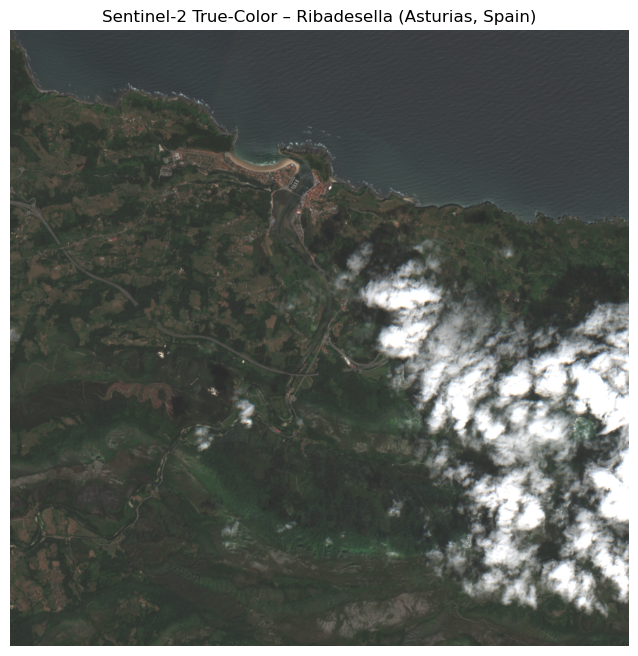

In [3]:
# Stack RGB and display
rgb = np.stack([bands_roi['B04'], bands_roi['B03'], bands_roi['B02']], axis = -1)
plt.figure(figsize = (8,8))
stretch = np.percentile(rgb, 98)
plt.imshow(rgb / stretch)
plt.title("Sentinel-2 True-Color – Ribadesella (Asturias, Spain)")
plt.axis('off')
plt.show()

A the natural-color view of the scene is generated by stacking the red, green, and blue bands. We apply a percentile stretch to enhance contrast without saturating outliers.

# Spectral Indeces 
A spectral index is a mathematical combination of two or more wavelengths that enhances the information content of the data. Spectral indices can be used to extract information about specific features or properties of the Earth’s surface, such as vegetation density, soil moisture, or water quality.

<b>Normalized Difference Vegetation Index (NDVI)<b>

NDVI is calculated from the visible and near-infrared light reflected by vegetation. Healthy vegetation absorbs most of the visible light that hits it and reflects a large portion of the near-infrared light. Unhealthy or sparse vegetation reflects more visible light and less near-infrared light.

NDVI for a given pixel always results in a number that ranges from minus one (-1) to plus one (+1). However, no green leaf gives a value close to zero. A zero means no vegetation, and close to +1 indicates the highest possible density of green leaves.

The NDVI is defined as:

$$
\mathrm{NDVI} = \frac{\rho_{\mathrm{NIR}} - \rho_{\mathrm{Red}}}{\rho_{\mathrm{NIR}} + \rho_{\mathrm{Red}}}
$$

Where:

- $\rho_{\mathrm{NIR}}$ is the surface reflectance in the near-infrared band (e.g. Sentinel-2 B08)  
- $\rho_{\mathrm{Red}}$ is the surface reflectance in the red band (e.g. Sentinel-2 B04)

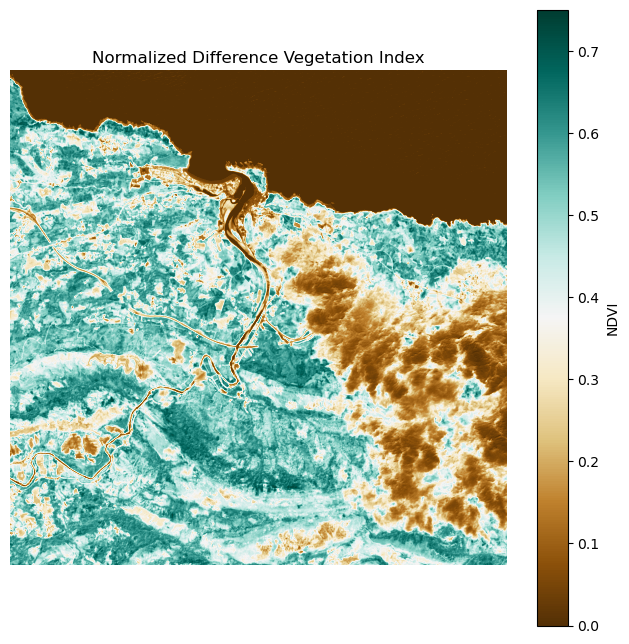

In [4]:
# NVDI
nir = bands_roi['B08']
red = bands_roi['B04']
ndvi = (nir - red) / (nir + red)

# Plot
plt.figure(figsize = (8,8))
plt.imshow(ndvi, vmin = 0, vmax = 0.75, cmap = 'BrBG') # vmin = 0 and vmax = 0.75 to enhance contrast
plt.colorbar(label = 'NDVI')
plt.title('Normalized Difference Vegetation Index')
plt.axis('off')
plt.show()

<b>Modified Normalized Difference Water Index (MNDWI)</b>

MNDWI is specifically tailored to highlight open‐water bodies because water absorbs strongly in the SWIR band and reflects green light, while built‐up areas and bare soil exhibit the opposite behavior. It produces values between –1 and +1, with positive values indicating water.  

$$
\mathrm{MNDWI} = \frac{\rho_{\mathrm{Green}} - \rho_{\mathrm{SWIR}}}{\rho_{\mathrm{Green}} + \rho_{\mathrm{SWIR}}}
$$

Where:

- $\rho_{\mathrm{Green}}$ is the surface reflectance in the green band (Sentinel-2 B03)  
- $\rho_{\mathrm{SWIR}}$ is the surface reflectance in the short-wave infrared band (Sentinel-2 B11)

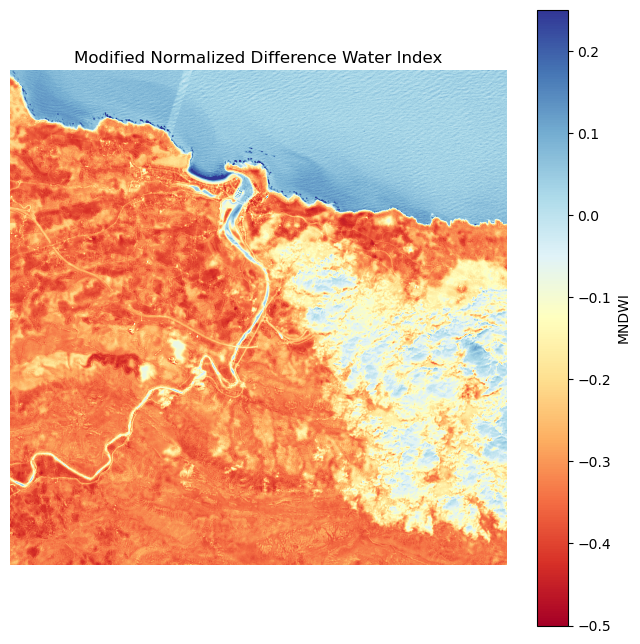

In [5]:
# MNDWI
green = bands_roi['B03']
swir = bands_roi['B11']
mndwi = (green - swir) / (green + swir)

# Plot
plt.figure(figsize = (8,8))
plt.imshow(mndwi, vmin = -0.5, vmax = 0.25, cmap = 'RdYlBu') # vmin = -0.5 and vmax = 0.25 to enhance contrast
plt.colorbar(label = 'MNDWI')
plt.title('Modified Normalized Difference Water Index')
plt.axis('off')
plt.show()

<b>Normalized Difference Built-up Index (NDBI)</b>

NDBI highlights urban or built-up areas by contrasting the SWIR band (which built surfaces reflect strongly) against the NIR band (which they reflect weakly). Values range from –1 to +1 where positive values typically correspond to built-up or impervious surfaces.

The NDBI is defined as:

$$
\mathrm{NDBI} = \frac{\rho_{\mathrm{SWIR}} - \rho_{\mathrm{NIR}}}{\rho_{\mathrm{SWIR}} + \rho_{\mathrm{NIR}}}
$$

Where:

- $\rho_{\mathrm{SWIR}}$ is the surface reflectance in the short-wave infrared band (e.g. Sentinel-2 B11)  
- $\rho_{\mathrm{NIR}}$ is the surface reflectance in the near-infrared band (e.g. Sentinel-2 B08)  

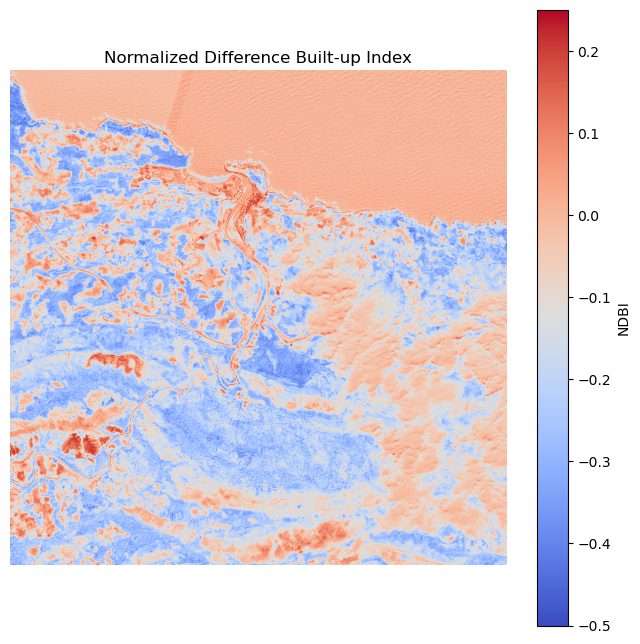

In [6]:
# NDBI
swir = bands_roi['B11']
nir = bands_roi['B08']
ndbi = (swir - nir) / (swir + nir)

# Plot
plt.figure(figsize = (8,8))
plt.imshow(ndbi, vmin = -0.5, vmax = 0.25, cmap = 'coolwarm') # vmin = -0.5 and vmax = 0.5 to enhance contrast
plt.colorbar(label = 'NDBI')
plt.title('Normalized Difference Built-up Index')
plt.axis('off')
plt.show()

<b>Normalized Difference Moisture Index (NDMI)</b>

NDMI is designed to quantify vegetation water content by leveraging the strong absorption of moisture in the SWIR band against the high reflectance in the NIR band. This contrast makes NDMI particularly sensitive to plant water stress, soil moisture deficits, and even canopy wetness after rainfall. It produces values between –1 and +1 where higher positive values correspond to well-hydrated, vigorous vegetation and lower or negative values indicate dry vegetation, sparse canopy cover, or exposed soil.  

$$
\mathrm{NDMI} = \frac{\rho_{\mathrm{NIR}} - \rho_{\mathrm{SWIR}}}{\rho_{\mathrm{NIR}} + \rho_{\mathrm{SWIR}}}
$$

Where:

- $\rho_{\mathrm{NIR}}$ is the surface reflectance in the near-infrared band (Sentinel-2 B08)  
- $\rho_{\mathrm{SWIR}}$ is the surface reflectance in the short-wave infrared band (Sentinel-2 B11)  

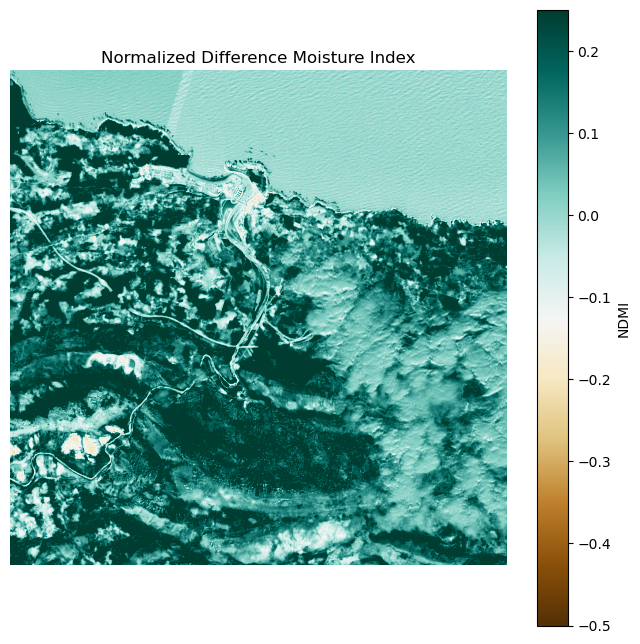

In [7]:
# NDMI
nir = bands_roi['B08']
swir = bands_roi['B11']
ndmi = (nir - swir) / (nir + swir)

# Plot
plt.figure(figsize = (8,8))
plt.imshow(ndmi, vmin = -0.5, vmax = 0.25, cmap = 'BrBG') # vmin = -0.5 and vmax = 0.25 to enhance contrast
plt.colorbar(label = 'NDMI')
plt.title('Normalized Difference Moisture Index')
plt.axis('off')
plt.show()

# Semantic Segmentation

In this section, we perform an unsupervised segmentation of a zoomed-in Sentinel-2 scene to explore the main land-cover classes without any manual labeling. By stacking multiple spectral bands (Red, Green, Blue, NIR, and SWIR) into a single feature vector for each pixel, we allow the clustering algorithm to leverage spectral information.

<b>K-Means Clustering<b>

We choose k = 5 clusters so that similar spectral signatures (e.g. open water, dense vegetation, urban areas, etc) are grouped together.

The resulting label map reveals distinct spectral regions, which can be inspected and later annotated as actual land-cover types or used as a guide for further supervised modeling. This unsupervised approach can be compared against index-based maps (NDVI, MNDWI, etc.) to validate their thematic consistency.

In [8]:
# Zoom in

# Define ROI in lon/lat
lat_r, lon_r = 43.4631, -5.0600
deg_per_km_lat = 1 / 111.0
deg_per_km_lon = 1 / (111.0 * np.cos(np.deg2rad(lat_r)))
lat_delta = 3.3 * deg_per_km_lat
lon_delta = 3.3 * deg_per_km_lon
south = lat_r - 0.5 * lat_delta
north = south + lat_delta
west = lon_r - lon_delta/2
east = lon_r + lon_delta/2

# Fetch STAC item
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[west, south, east, north],
    datetime="2023-08-01/2023-08-07",
    limit=1
)
item = next(search.get_items())
signed = pc.sign(item)

# Open B08 first to get master window *and* its true shape
with rasterio.open(signed.assets['B08'].href) as src_nir:
    wN, sN, eN, nN = transform_bounds(
        "EPSG:4326", src_nir.crs, west, south, east, north
    )
    window = from_bounds(wN, sN, eN, nN, src_nir.transform)

    # Read the window into memory
    nir = src_nir.read(1, window=window).astype('float32')

    # Now pull the *actual* array shape instead of window.xxx
    height, width = nir.shape

    # And grab the transform & CRS for reprojection
    out_transform = rasterio.windows.transform(window, src_nir.transform)
    out_crs       = src_nir.crs

bands_roi = {'B08': nir}

# Clip the other 10 m bands exactly the same way
for band in ['B04','B03','B02']:
    with rasterio.open(signed.assets[band].href) as src:
        bands_roi[band] = src.read(1, window=window).astype('float32')

# Allocate the SWIR buffer to match the *exact* NIR shape
swir_on_nir = np.empty((height, width), dtype='float32')

# Reproject B11 into that grid
with rasterio.open(signed.assets['B11'].href) as src_swir:
    reproject(
        source      = src_swir.read(1),
        destination = swir_on_nir,
        src_transform = src_swir.transform,
        src_crs       = src_swir.crs,
        dst_transform = out_transform,
        dst_crs       = out_crs,
        resampling    = Resampling.bilinear
    )
bands_roi['B11'] = swir_on_nir

# Sanity check—all shapes are now identical:
for b, arr in bands_roi.items():
    print(f"{b:>4s} → {arr.shape}")

/opt/anaconda3/envs/py3/lib/python3.11/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


 B08 → (338, 340)
 B04 → (338, 340)
 B03 → (338, 340)
 B02 → (338, 340)
 B11 → (338, 340)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3345277..2.7283387].


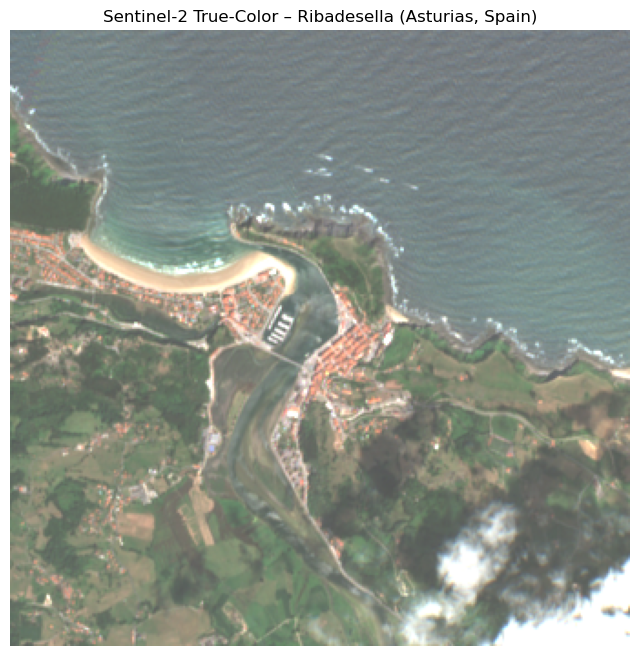

In [9]:
# Stack RGB and display
rgb = np.stack([bands_roi['B04'], bands_roi['B03'], bands_roi['B02']], axis = -1)
plt.figure(figsize = (8,8))
stretch = np.percentile(rgb, 98)
plt.imshow(rgb / stretch)
plt.title("Sentinel-2 True-Color – Ribadesella (Asturias, Spain)")
plt.axis('off')
plt.show()

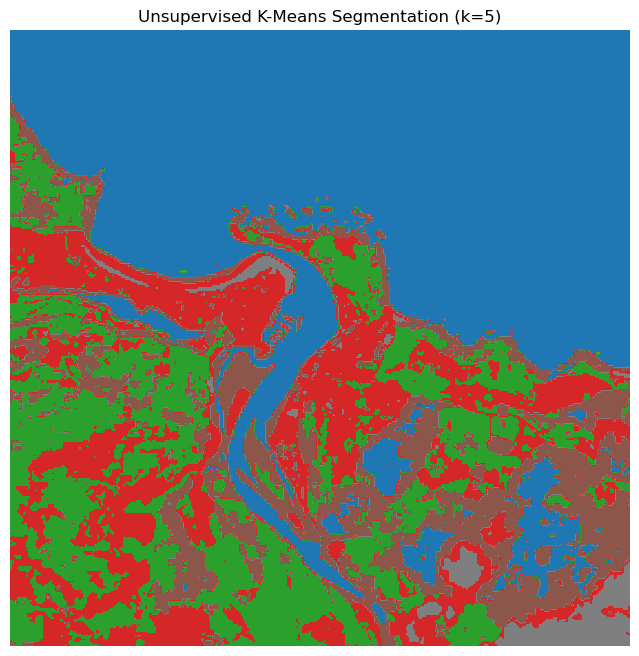

In [10]:
# Segmentation model

# Build a multi-band feature array: stack R, G, B, NIR, SWIR into (H*W, 5)
feat_stack = np.stack([
    bands_roi['B04'],  # Red
    bands_roi['B03'],  # Green
    bands_roi['B02'],  # Blue
    bands_roi['B08'],  # NIR
    bands_roi['B11'],  # SWIR (already on the same grid)
], axis = -1)
h, w, n = feat_stack.shape
flat_feats = feat_stack.reshape((h*w, n))

# Run K-Means (choose k classes)
k = 5
km = KMeans(n_clusters=k, random_state = 42, n_init = 10)
labels = km.fit_predict(flat_feats)

# Reshape labels back into image
label_map = labels.reshape(h, w)

# Visualize clusters
cmap = mcolors.ListedColormap(['tab:blue', 'tab:green', 'tab:red', 'tab:gray', 'tab:brown'][:k])
plt.figure(figsize = (8,8))
plt.imshow(label_map, cmap = cmap)
plt.title(f'Unsupervised K-Means Segmentation (k={k})')
plt.axis('off')
plt.show()

# Conclusion

In this notebook we have:

<b>Spectral Indices<b>
   - Computed NDVI to highlight vegetation health, MNDWI for open‐water bodies, NDBI for built‐up areas, and NDMI for moisture content.  
   - Visual inspection of these maps confirmed our expectations: high NDVI over vegetated areas, positive MNDWI over water, etc.

<b>Semantic Segmentation<b>
   - Stacked five core bands (R, G, B, NIR, SWIR) into a 5-dimensional feature space and ran K-Means with \(k=5\).  
   - The resulting clusters roughly corresponded to major land-cover types (water, dense vegetation, urban/built-up, shaded areas, clouds), providing a rapid thematic overview.

<b>Next Steps<b>
   - By inspecting each cluster’s mean spectrum (and comparing to our index maps), we could assign semantic labels (e.g. “Cluster 0 = water”, “Cluster 1 = forest”).
   - These pseudo-labels can seed a supervised classifier or feed into a deep-learning U-Net using the same multi-band stack plus derived indices for improved accuracy.
   - To refine the map collect a small set of ground-truth polygons, train a Random Forest or U-Net, and validate quantitatively.

Overall, this workflow demonstrates how to go from raw Sentinel-2 imagery to thematic land-cover segmentation, combining physics-based indices with both classical clustering and the groundwork for supervised or deep-learning approaches. Future enhancements could include adding texture or elevation data, experimenting with different clustering algorithms, or scaling to larger areas.